In [2]:
!pip install opencv-python tqdm matplotlib numpy ipywidgets
!jupyter nbextension enable --py widgetsnbextension
!pip3 install tdmclient --upgrade


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


# Computer vision

Goals : The aim of this code is :
- to stream a USB camera;
- to recognize on the video frames the robot, the starting point, the goal and the obstacles;
- to provide the respective positions of the aforthmentionned objects in a map.

The tracking of the different objects is done by template matching. The estimation of the real distances can be realized with given known references.



In [3]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import IPython
from IPython.display import display, clear_output



# Activity 2 - Image Tracking

You can track the position of an object in an image by using what is called template matching. Let's apply template matching on a video of the Thymio robot following a line and attempt to track the position of the robot throughout the video using the different techniques that opencv provides. 

First we are going to load the video and store the different frames. 




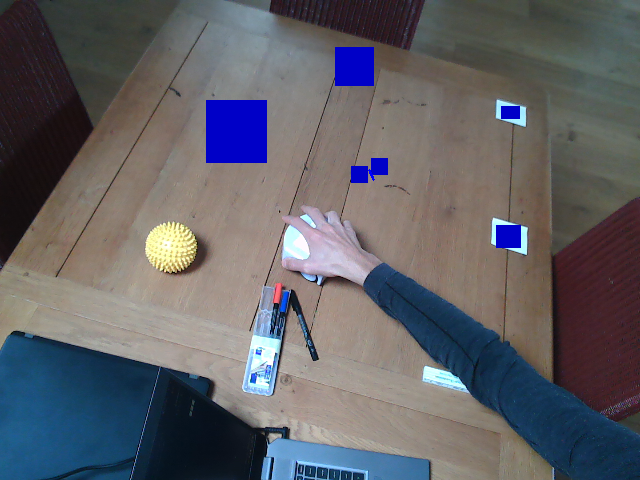

There are 400 frames in the video


In [60]:
def find_camera_index(i):
    cap = cv2.VideoCapture(i)
    if cap.isOpened():
        print(f"Camera index {i} found.")
        cap.release()
        return(i)
    else:
        print(f"No camera found at index {i}.")
        return find_camera_index(i+1)

def show_frame(frame):
    _, img_encoded = cv2.imencode('.png', frame)
    IPython.display.display(IPython.display.Image(data=img_encoded.tobytes()))

class Map:
    def __init__(self, ref1 = np.array([1, 0]), 
                 ref2 = np.array([0, 0]), ref3 = np.array([0, 1]),
                 distance_r1r2 = 400, distance_r3r2 = 400):
        self.ref1 = ref1
        self.ref2 = ref2
        self.ref3 = ref3
        self.origin = [0, 0]
        self.e1 = ref1 - ref2/np.linalg.norm(ref1 - ref2)
        self.e2 = ref3 - ref2/np.linalg.norm(ref3 - ref2)
        self.scale1 = distance_r1r2/np.linalg.norm(ref1 - ref2)
        self.scale2 = distance_r3r2/np.linalg.norm(ref3 - ref2)
        
    #def object_map_pos():

        
class Object2:
    def __init__(self, pattern, position = [0, 0]):
        self.pattern = pattern
        self.color, self.width, self.height = pattern.shape[::-1]
        self.position = position
    
    def tracking(self, frame, match_treshold = 0.8):
        res = cv2.matchTemplate(frame,self.pattern,cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        if max_val > match_treshold:
            self.position = np.array([max_loc[0] + self.width // 2, max_loc[1] + self.height // 2])
        return

class Robot:
    def __init__(self, left_mark, right_mark, position = np.array([0, 0]), direction = np.array([0, 0])):
        self.left_mark = left_mark
        self.right_mark = right_mark
        self.position = position
        self.direction = direction

    def update_localization(self, frame):
        self.left_mark.tracking(frame)
        self.right_mark.tracking(frame)

        self.position = np.array([(left_mark.position[0] + right_mark.position[0])//2, (left_mark.position[1] + right_mark.position[1])//2])
        self.direction = np.array([(left_mark.position[1] - right_mark.position[1]), (-(left_mark.position[0] - right_mark.position[0]))])
        self.direction = self.direction/np.linalg.norm(self.direction)
        return


def object_highlight(frame, object2):
    cv2.rectangle(frame, [object2.position[0] - object2.width // 2, object2.position[1] - object2.height // 2], 
                    [object2.position[0] + object2.width // 2, object2.position[1] + object2.height // 2], (200, 0, 0), -1)
    return




robot_led1_template = cv2.imread('right_mark.jpg')
robot_led2_template = cv2.imread('left_mark.jpg')

left_mark = Object2(robot_led2_template)
right_mark = Object2(robot_led1_template)

robot = Robot(left_mark,right_mark)

goal_template = cv2.imread('goal.jpg')
goal = Object2(goal_template)

ref1_template = cv2.imread('ref1.jpg')
ref2_template = cv2.imread('ref2.jpg')
ref3_template = cv2.imread('ref3.jpg')

ref1 = Object2(ref1_template)
ref2 = Object2(ref2_template)
ref3 = Object2(ref3_template)

template_matching_on_video = []

i = 0
cap = cv2.VideoCapture(i)
# Check if camera opened successfully
""" while not cap.isOpened():
    cap = cv2.VideoCapture(i)
    print(f"No camera found at index {i}.")
    i += 1
 """
video_imgs = []



for i in range(400):
    ret, frame = cap.read()
    if ret == True:
        video_imgs.append(frame)

        robot.update_localization(frame)
        object_highlight(frame, robot.left_mark)
        object_highlight(frame, robot.right_mark)

        
        goal.tracking(frame)
        object_highlight(frame, goal)
        
        cv2.line(frame, robot.position, np.add(robot.position,np.round(10*robot.direction).astype(int)), (255, 0, 0), 2)

        ref1.tracking(frame)
        object_highlight(frame, ref1)    
        ref2.tracking(frame)
        object_highlight(frame, ref2)
        ref3.tracking(frame)
        object_highlight(frame, ref3)

        clear_output(wait=True)

        show_frame(frame)


    #if np.sum(abs(goal.position-robot.position) < 5) > 0:
        #break
    # Break the loop
    
        
print("There are {} frames in the video".format(len(video_imgs)))

In [144]:
help(cv2.minMaxLoc)

Help on built-in function minMaxLoc:

minMaxLoc(...)
    minMaxLoc(src[, mask]) -> minVal, maxVal, minLoc, maxLoc
    .   @brief Finds the global minimum and maximum in an array.
    .   
    .   The function cv::minMaxLoc finds the minimum and maximum element values and their positions. The
    .   extremums are searched across the whole array or, if mask is not an empty array, in the specified
    .   array region.
    .   
    .   The function do not work with multi-channel arrays. If you need to find minimum or maximum
    .   elements across all the channels, use Mat::reshape first to reinterpret the array as
    .   single-channel. Or you may extract the particular channel using either extractImageCOI , or
    .   mixChannels , or split .
    .   @param src input single-channel array.
    .   @param minVal pointer to the returned minimum value; NULL is used if not required.
    .   @param maxVal pointer to the returned maximum value; NULL is used if not required.
    .   @param m

Define the templates of :
1) the robot : defined as a red and a green led
2) the starting point
3) the goal
4) the obstacles : blue shapes

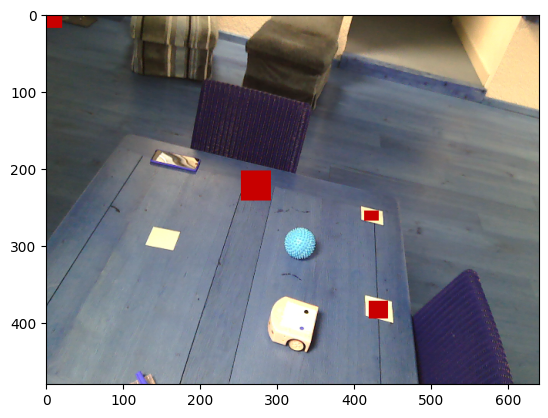

In [55]:
template = video_imgs[40]
cv2.imwrite('objects.jpg', template)

plt.imshow(template)

#cv2.imwrite('robot.jpg', template)
#cv2.imwrite('goal.jpg', template)
#cv2.imwrite('ref1.jpg', template)
#cv2.imwrite('ref2.jpg', template)
#cv2.imwrite('ref3.jpg', template)



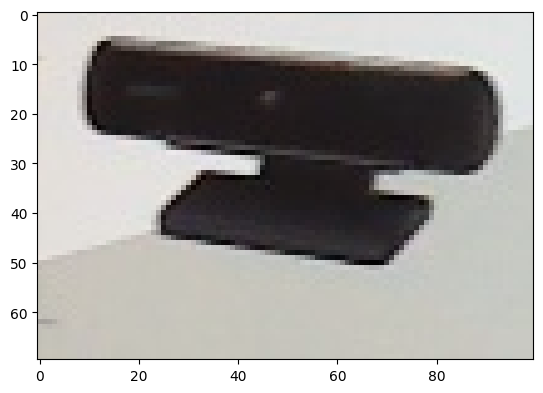

In [15]:
frame_width = int(cap.get(3)) 
frame_height = int(cap.get(4)) 
   
size = (frame_width, frame_height)
result = cv2.VideoWriter('test_tracking.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 20, size)
for f in range(len(template_matching_on_video)):
    result.write(template_matching_on_video[f])
#dir = r'C:\Users\eaell\Documents\epfl\ma1\MICRO-452 Basics of mobile robotics\project'
#cv2.imwrite('test_tracking2.jpg', template)

Now have a look at the opencv tutorial [here](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_template_matching/py_template_matching.html) and apply the different template matching techniques on the image and the template. 

***Which methods seems the most robust and why?***

<span style="color: #2980B9 ;">

>Looking at the matching results, it would seem that cv2.TM_CCOEFF_NORMED gives the highest contrast between the found point and the rest.
</span>


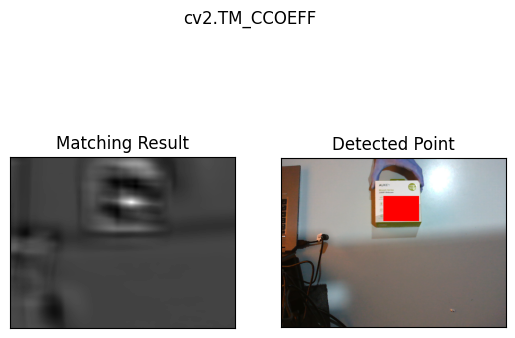

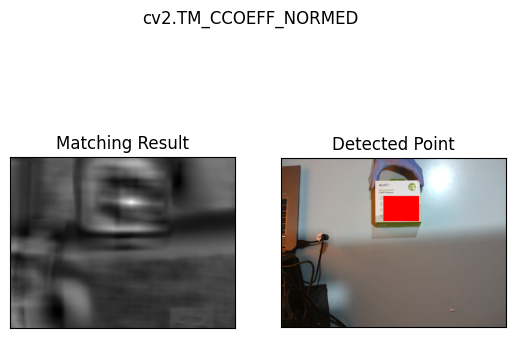

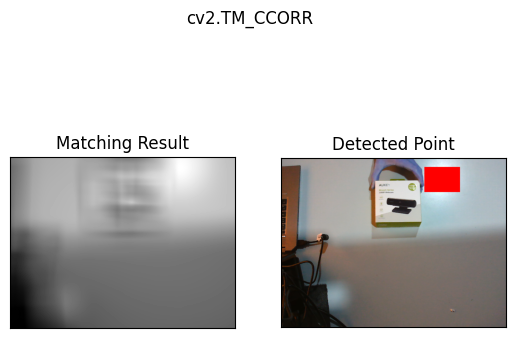

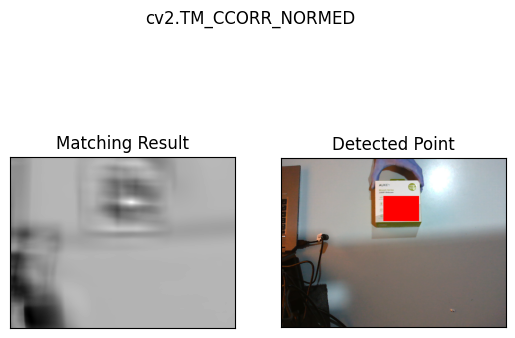

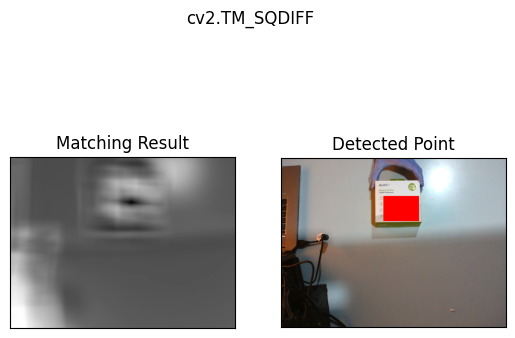

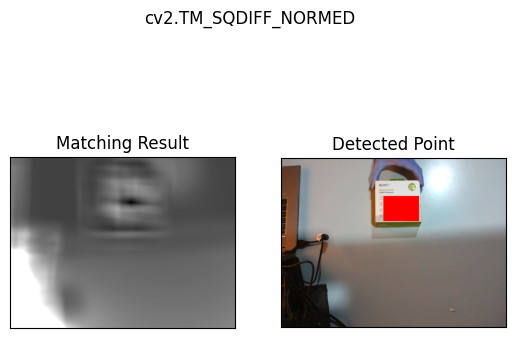

In [31]:
c, w, h  = template.shape[::-1]

methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

for meth in methods:
    method = eval(meth)
    img = video_imgs[30].copy()
    
    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    cv2.rectangle(img,top_left, bottom_right, (255, 0, 0), -1)
    
    plt.figure()
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)

    plt.show()

Once you have selected the algorithm that you believe to be the most appropriate, apply it to the set of images that were extracted from the video. To visualise the result of the process, we have provided a browse images function which when provided the individual images lets you nagivate through them with a slider. 

***What are the limitations of template matching?***
  
<span style="color: #2980B9 ;">
    
> "Pattern occurrences have to preserve the orientation of the reference pattern image (template). As a result, it does not work for rotated or scaled versions of the template as a change in shape/size/shear etc. of object w.r.t. template will give a false match. The method is inefficient when calculating the pattern correlation image for medium to large images as the process is time consuming." (see [here](https://www.geeksforgeeks.org/template-matching-using-opencv-in-python/) for more details)


</span>


In [32]:
from tqdm import tqdm 

template_matching_on_video = []
titles = []

for idx_frame in tqdm(range(len(video_imgs))):
    img = video_imgs[idx_frame].copy()

    # Apply template Matching
    res = cv2.matchTemplate(img,template,cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    
    titles.append("Frame {}, top left corner of thymio located at {}".format(idx_frame, top_left))
    cv2.rectangle(img, top_left, bottom_right, (255, 0, 0), -1)
    template_matching_on_video.append(img)


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:03<00:00, 15.25it/s]


In [33]:
from ipywidgets import interact

%matplotlib inline

def browse_images(images, titles = None):
    if titles == None:
        titles = [i for i in range(len(images))]
        
    n = len(images)
    def view_image(i):
        plt.imshow(images[i], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title(titles[i], y=-0.5)
        plt.show()
    interact(view_image, i=(0,n-1))

browse_images(template_matching_on_video, titles)


interactive(children=(IntSlider(value=24, description='i', max=49), Output()), _dom_classes=('widget-interact'…

**/!\ If you have problems with the slider widget, make sure you have installed and activated the jupyter-js-widgets/extension (see https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/install.html)**

# Activity 3 - Implementing the Hough Transform to Identify Straight Lines in an Image

The goal of this exercise is going to be to code the Hough transform to identify straight lines in an image. We are going to use the following image throughout the exercise in order to test the different steps. The image is located in the Images folder under ``pentagon.png``

As this is one of your first "big" coding exercises we are going to guide you through it. 

<br/>

![Pentagon](images/pentagon.png)

<br/>

## Importing the libraries 

We are going to need the :

- `opencv` for image processing

- `math` for the trigonometry functions

- `numpy` for array processing

- `matplotlib` for plotting


In [ ]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt 

## Loading and displaying the image

Start by giving the filename with the full path so that the mpimg module can load the image with the imread function. 

Then display the image object with plt.imshow()

In [ ]:
filename = 'images/pentagon.png'
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

plt.imshow(img)

## Creating the hough transform matrix

1. We start by creating a numpy array of arbitrary dimensions. 

In [ ]:
# We choose to have a final matrix of the following
# dimensions. This is an arbitrary decision

r_dim = 200 
theta_dim = 300

# Creating the empty hough transform matrix
hough_space = np.zeros((r_dim,theta_dim))

2. Now we need to relate the dimensions of this new matrix to the corresponding values along the rho and theta axes. This means we need to determine the minimum and maximum values of theta and rho. 

In [ ]:
# Get theta min and theta max
theta_max = 1.0 * math.pi 
theta_min = 0.0

# From the image shape, determine rho min and rho max
(x_max, y_max) = img.shape
r_min = 0.0
r_max = math.hypot(x_max, y_max)


Now we are going to compute the hough transform of the original image. The pseudo code is the following :

    for all pixels:
        if the pixel is white:
              do nothing
        else:
            for theta values :
                compute rho from the pixel coordinates and theta
                convert rho to the image space
                update the hough space matrix for the theta and rho coordinates in the array
                
                
You should get a result similar to this one 


<br/>

![Pentagon](Images/houghTransform.png)

<br/>

In [ ]:

for x in range(x_max):
    for y in range(y_max):
        if img[x,y] == 255: continue
        for idx_theta in range(theta_dim):
            theta = 1.0 * idx_theta * theta_max / theta_dim
            r = x * math.cos(theta) + y * math.sin(theta)
            ir = r_dim * ( 1.0 * r ) / r_max
            hough_space[int(ir),int(idx_theta)] += 1
            
            
# Plotting function
plt.imshow(hough_space, origin='lower')
plt.xlim(0,theta_dim)
plt.ylim(0,r_dim)

tick_locs = [i for i in range(0,theta_dim,40)]
tick_lbls = [round( (1.0 * i * theta_max) / theta_dim,1) for i in range(0,theta_dim,40)]
plt.xticks(tick_locs, tick_lbls)

tick_locs = [i for i in range(0,r_dim,20)]
tick_lbls = [round( (1.0 * i * r_max ) / r_dim,1) for i in range(0,r_dim,20)]
plt.yticks(tick_locs, tick_lbls)

plt.xlabel(r'$\Theta$')
plt.ylabel(r'$\rho$')
plt.title('Hough Space')


## Identifying the maxima of the Hough Transform

After calculating the Hough space, the next step is to find the local extrema. This will give us the rho and theta parameters of the different straight lines in the image. 

To find the extrema, we will do the following :

1. isolate the brightest spots

2. enlarge the size of the spots

3. find the centroid of the spots

### Isolating the brightest spots through thresholding

To isolate the bright spots and remove the gradients around the maxima we are going to apply **thresholding** to convert the image into 0's for the dark areas and 1's around the maximas. Have a look [here](https://docs.opencv.org/master/d7/d4d/tutorial_py_thresholding.html) at the different thresholding functions that opencv has to offer. 

Play with the parameters to try to obtain an image similar to this one 


<br/>

![Pentagon](images/thresholding_output.png)

<br/>

In [ ]:
# First we convert the pixels to uint8 in order to apply the thresholding
converted_hough_space = cv2.convertScaleAbs(hough_space)
_, thresholded_hough_space = cv2.threshold(converted_hough_space,180,255,cv2.THRESH_BINARY)
plt.imshow(thresholded_hough_space, origin='lower')


tick_locs = [i for i in range(0,theta_dim,40)]
tick_lbls = [round( (1.0 * i * theta_max) / theta_dim,1) for i in range(0,theta_dim,40)]
plt.xticks(tick_locs, tick_lbls)

tick_locs = [i for i in range(0,r_dim,20)]
tick_lbls = [round( (1.0 * i * r_max ) / r_dim,1) for i in range(0,r_dim,20)]
plt.yticks(tick_locs, tick_lbls)

plt.xlabel(r'$\Theta$')
plt.ylabel(r'$\rho$')
plt.title('Hough Space')

plt.savefig("../Exercises/images/thresholding_output.png")
plt.savefig("./images/thresholding_output.png")

plt.show()

### Enlarging the size of the spots through morphological operators

To identify the location of the local maxima, we will make use of find contours. However the spots in the image are too small to apply the opencv functions. That is why we are going to start by increasing their size through morphological operations. Have a look [here](https://docs.opencv.org/master/d9/d61/tutorial_py_morphological_ops.html) to see the different operators and their effect on a binary image. 


You should get an image like this one : 

<br/>

![Pentagon](images/morphological_output.png)

<br/>

In [ ]:
kernel = np.ones((2,2),np.uint8)
hough_maxima = cv2.dilate(thresholded_hough_space, kernel, iterations = 1)
plt.imshow(hough_maxima, origin='lower')


tick_locs = [i for i in range(0,theta_dim,40)]
tick_lbls = [round( (1.0 * i * theta_max) / theta_dim,1) for i in range(0,theta_dim,40)]
plt.xticks(tick_locs, tick_lbls)

tick_locs = [i for i in range(0,r_dim,20)]
tick_lbls = [round( (1.0 * i * r_max ) / r_dim,1) for i in range(0,r_dim,20)]
plt.yticks(tick_locs, tick_lbls)

plt.xlabel(r'$\Theta$')
plt.ylabel(r'$\rho$')
plt.title('Hough Space')

plt.savefig("../Exercises/images/morphological_output.png")
plt.savefig("./images/morphological_output.png")


### Identifying the Centroids' Locations Through Contours 

Now we have bigger spots and we are going to use Opencv's built in functions to find the contours and deduce the location of the centroid in the hough space. [An example is provided here](https://www.learnopencv.com/find-center-of-blob-centroid-using-opencv-cpp-python/). 

You should get a result similar to this one : 


<br/>

![Pentagon](images/centroid_output.png)

<br/>

In [ ]:
# find contours in the binary image
output = hough_maxima.copy()
contours, hierarchy = cv2.findContours(hough_maxima,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

#Converting to color for the visualisation
output = cv2.cvtColor(output,cv2.COLOR_GRAY2RGB) 

maxima_locs = []

for c in contours:
    # calculate moments for each contour
    M = cv2.moments(c)

    # calculate x, y coordinate of center
    cX = int(M["m10"] / M["m00"])
    cY = int(M["m01"] / M["m00"])
    
    maxima_locs.append((cX, cY))
    cv2.circle(output, (cX, cY), 2, (255, 0, 0), -1)
    
# display the image
plt.imshow(output, origin="lower")


tick_locs = [i for i in range(0,theta_dim,40)]
tick_lbls = [round( (1.0 * i * theta_max) / theta_dim,1) for i in range(0,theta_dim,40)]
plt.xticks(tick_locs, tick_lbls)

tick_locs = [i for i in range(0,r_dim,20)]
tick_lbls = [round( (1.0 * i * r_max ) / r_dim,1) for i in range(0,r_dim,20)]
plt.yticks(tick_locs, tick_lbls)

plt.xlabel(r'$\Theta$')
plt.ylabel(r'$\rho$')
plt.title('Hough Space')

plt.savefig("../Exercises/images/centroid_output.png")
plt.savefig("./images/centroid_output.png")


## Computing the location of the straight lines in the original image and drawing them

With the maxima obtained, we can now compute the corresponding segments in the original image. You should get a result similar to this one. 


<br/>

![Pentagon](images/hough_transform.png)

<br/>


In [ ]:
fig, ax = plt.subplots()
ax.imshow(img)
ax.autoscale(False)

for (j,i) in maxima_locs:

    r = round( (1.0 * i * r_max ) / r_dim,1)
    theta = round( (1.0 * j * theta_max) / theta_dim,1)

    px = []
    py = []
    
    for i in range(-y_max-40,y_max+40,1):
        px.append( math.cos(-theta) * i - math.sin(-theta) * r ) 
        py.append( math.sin(-theta) * i + math.cos(-theta) * r )

    ax.plot(px,py, linewidth=1, color="r")

plt.savefig("../Exercises/images/hough_transform.png")
plt.savefig("./images/hough_transform.png")

plt.show()

# Robot leds setting for tracking

In [59]:
import tdmclient.notebook
await tdmclient.notebook.start()

In [60]:
leds_top=[0,0,0]
leds_bottom_left=[0,0,0]
leds_bottom_right=[0,0,0]
leds_circle = [0,0,0,0,0,0,0,0]
leds_prox_h = [32,32,32,32,32,32,32,32]
leds_prox_v = [0,0]
leds_buttons = [0,0,0,0]
leds_rc = [0]
leds_temperature = [0,0]

In [56]:
await tdmclient.notebook.stop()